## Import


In [1]:
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
import matplotlib.pyplot as plt
import glob
import fiona
import geopandas as gpd
from dbfread import DBF
from pyproj import CRS
import shapefile  # pyshp
import os
import pyodbc
from rasterio.plot import show
from rasterio.enums import Resampling # ✅ Import Resampling
from shapely.geometry import Point
import numpy as np
os.makedirs("out", exist_ok=True)




## Climate Dataset


Tmax : 60 fichiers

 Tmax – Exploring file: wc2.1_cruts4.09_5m_tmax_2020-01.tif
CRS: EPSG:4326
Dimensions: 4320 x 2160
Number of bands: 1
Resolution: (0.08333333333333333, 0.08333333333333333)
Bounds: BoundingBox(left=-180.0, bottom=-90.0, right=180.0, top=90.0)
Data type: float32


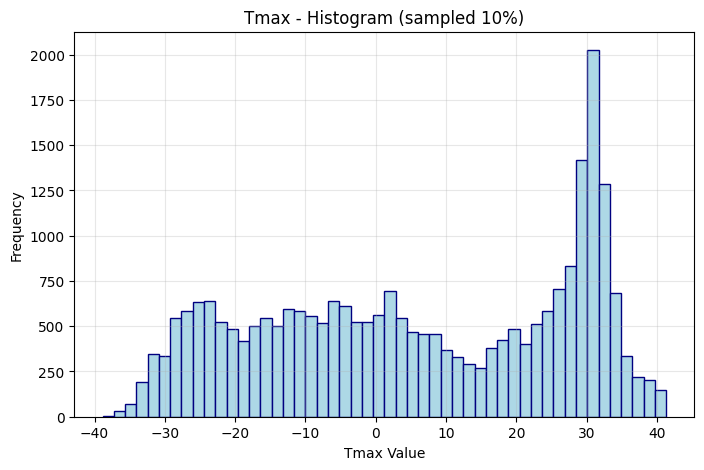

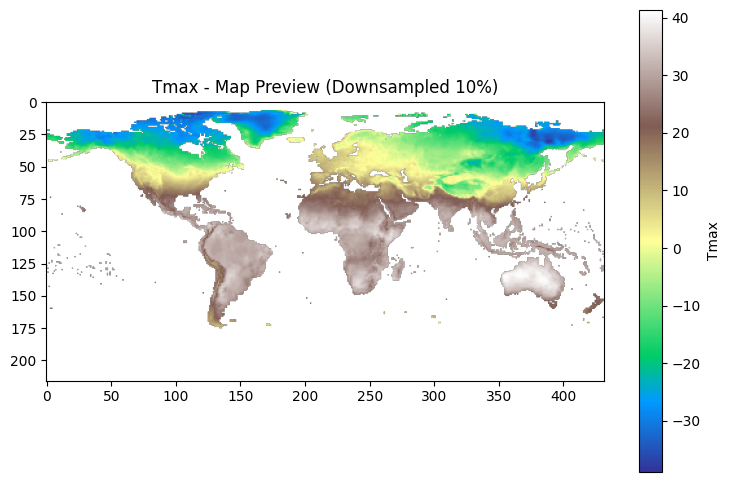

Tmin : 60 fichiers

 Tmin – Exploring file: wc2.1_cruts4.09_5m_tmin_2020-01.tif
CRS: EPSG:4326
Dimensions: 4320 x 2160
Number of bands: 1
Resolution: (0.08333333333333333, 0.08333333333333333)
Bounds: BoundingBox(left=-180.0, bottom=-90.0, right=180.0, top=90.0)
Data type: float32


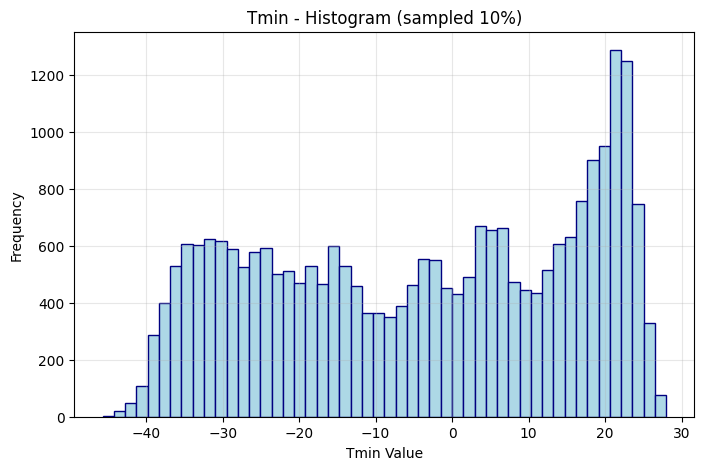

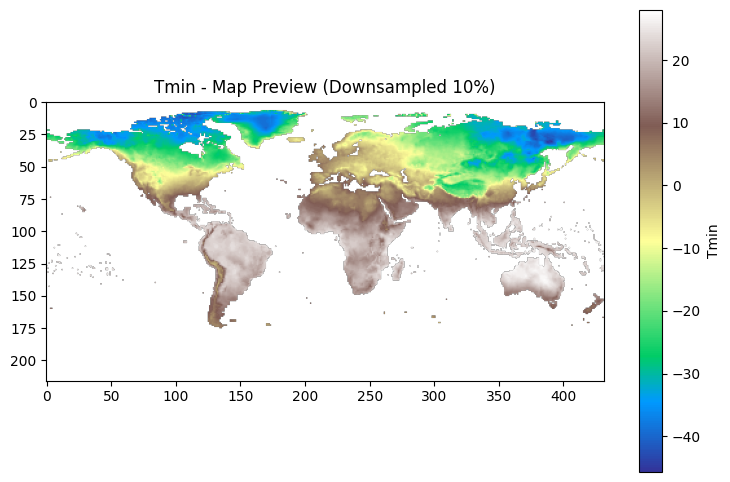

Précipitations : 60 fichiers

 Précipitations – Exploring file: wc2.1_cruts4.09_5m_prec_2020-01.tif
CRS: EPSG:4326
Dimensions: 4320 x 2160
Number of bands: 1
Resolution: (0.08333333333333333, 0.08333333333333333)
Bounds: BoundingBox(left=-180.0, bottom=-90.0, right=180.0, top=90.0)
Data type: float32


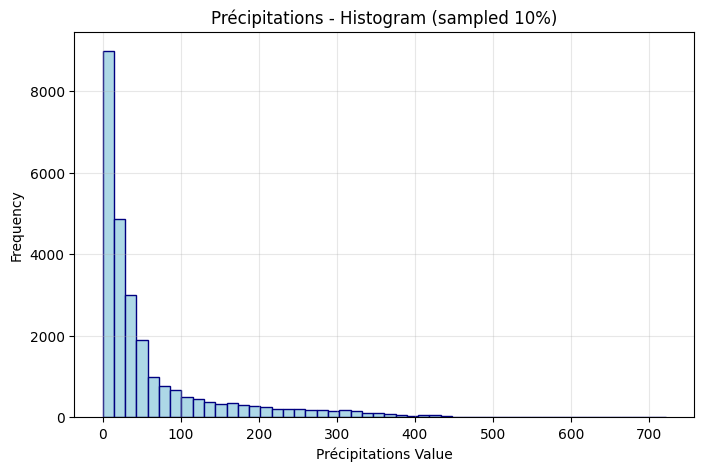

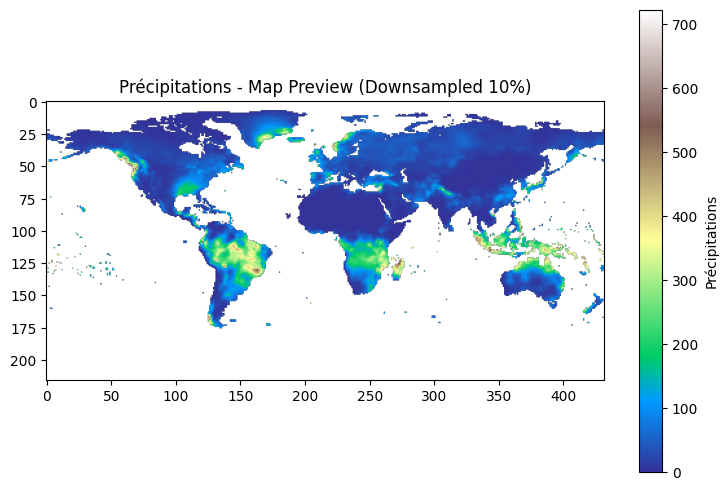

In [2]:
# === Helper function to explore raster datasets ===
def explore_raster(file_path, name, scale=0.1):
    print(f"\n {name} – Exploring file: {os.path.basename(file_path)}")
    
    with rasterio.open(file_path) as src:
        print("CRS:", src.crs)
        print("Dimensions:", src.width, "x", src.height)
        print("Number of bands:", src.count)
        print("Resolution:", src.res)
        print("Bounds:", src.bounds)
        print("Data type:", src.dtypes[0])
        
        # Downsample for safe reading
        new_height = int(src.height * scale)
        new_width = int(src.width * scale)
        
        data = src.read(
            1,
            out_shape=(1, new_height, new_width),
            resampling=Resampling.average
        )
        data = np.ma.masked_equal(data, src.nodata)
    
    # Compute stats
    valid = data.compressed()


    # Plot histogram
    plt.figure(figsize=(8, 5))
    plt.hist(valid, bins=50, color="lightblue", edgecolor="navy")
    plt.title(f"{name} - Histogram (sampled {int(scale*100)}%)")
    plt.xlabel(f"{name} Value")
    plt.ylabel("Frequency")
    plt.grid(alpha=0.3)
    plt.show()

    # Plot preview
    plt.figure(figsize=(9, 6))
    plt.imshow(data, cmap='terrain')
    plt.colorbar(label=f"{name}")
    plt.title(f"{name} - Map Preview (Downsampled {int(scale*100)}%)")
    plt.show()

# === Tmax ===
tmax_paths = sorted(glob.glob("../climate_dataset/5min/max/*.tif"))
print(f"Tmax : {len(tmax_paths)} fichiers")
if tmax_paths:
    explore_raster(tmax_paths[0], "Tmax")

# === Tmin ===
tmin_paths = sorted(glob.glob("../climate_dataset/5min/min/*.tif"))
print(f"Tmin : {len(tmin_paths)} fichiers")
if tmin_paths:
    explore_raster(tmin_paths[0], "Tmin")

# === Precipitations ===
prec_paths = sorted(glob.glob("../climate_dataset/5min/prec/*.tif"))
print(f"Précipitations : {len(prec_paths)} fichiers")
if prec_paths:
    explore_raster(prec_paths[0], "Précipitations")

## Elevation Dataset

✅ Raster loaded successfully

CRS: EPSG:4326
Dimensions: 86400 x 33600
Number of bands: 1
Resolution (pixel size): (0.004166666666666664, 0.004166666666666664)
Bounds: BoundingBox(left=-180.00013888888893, bottom=-56.00013888888891, right=179.99986111111085, top=83.999861111111)
Data type: int16

📊 Elevation Statistics:
  Min: -412
  Max: 6612
  Mean: 179.93176311728396
  Std Dev: 514.5679104952976
  Number of valid pixels: 7257600


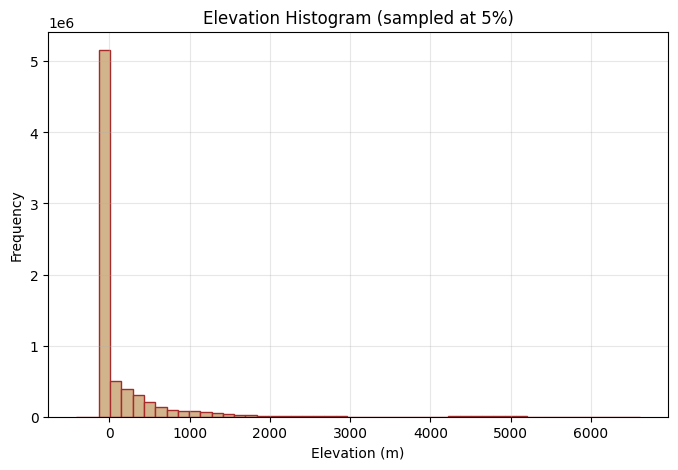

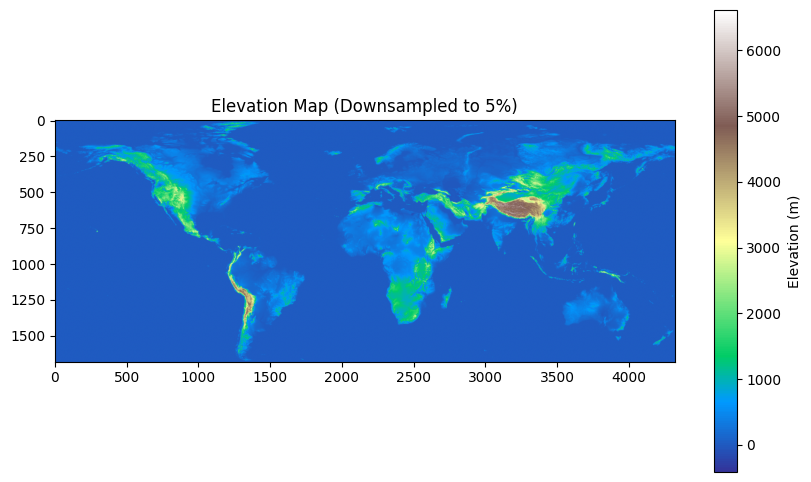

In [3]:
import rasterio
from rasterio.enums import Resampling
import numpy as np
import matplotlib.pyplot as plt
import os

# === 1. Define the file path ===
raster_file = "../elevation_dataset/be15_grd/w001001.adf"

# === 2. Open the raster ===
with rasterio.open(raster_file) as src:
    print("✅ Raster loaded successfully\n")
    print("CRS:", src.crs)
    print("Dimensions:", src.width, "x", src.height)
    print("Number of bands:", src.count)
    print("Resolution (pixel size):", src.res)
    print("Bounds:", src.bounds)
    print("Data type:", src.dtypes[0])

    # === 3. Read a downsampled version to explore ===
    scale = 0.05  # 5% resolution
    new_height = int(src.height * scale)
    new_width = int(src.width * scale)
    elevation = src.read(
        1,
        out_shape=(1, new_height, new_width),
        resampling=Resampling.average
    )

    # Mask invalid values (if any)
    elevation = np.ma.masked_equal(elevation, src.nodata)

# === 4. Compute elevation statistics ===
valid_pixels = elevation.compressed()  # remove masked values

print("\n📊 Elevation Statistics:")
print("  Min:", np.min(valid_pixels))
print("  Max:", np.max(valid_pixels))
print("  Mean:", np.mean(valid_pixels))
print("  Std Dev:", np.std(valid_pixels))
print("  Number of valid pixels:", len(valid_pixels))

# === 5. Plot histogram ===
plt.figure(figsize=(8, 5))
plt.hist(valid_pixels, bins=50, color="tan", edgecolor="brown")
plt.title("Elevation Histogram (sampled at 5%)")
plt.xlabel("Elevation (m)")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()

# === 6. Plot the downsampled elevation map ===
plt.figure(figsize=(10, 6))
plt.imshow(elevation, cmap='terrain')
plt.colorbar(label="Elevation (m)")
plt.title("Elevation Map (Downsampled to 5%)")
plt.show()


## Land Dataset

✅ Landcover Algérie chargé avec succès!

📂 Nombre de lignes : 386454
📋 Colonnes : ['ID', 'GRIDCODE', 'AREA', 'LCCCODE', 'geometry']

🗺️ Type de géométrie : ['Polygon']
🌍 Système de coordonnées : EPSG:4326

🔹 Aperçu des 5 premières lignes :


,ID,GRIDCODE,AREA,LCCCODE,geometry
0,4,210,6.228187e+06,7001 // 8001,"POLYGON ((6.41528 37.08696, 6.43103 37.0855, 6..."
1,2,210,6.242408e+06,7001 // 8001,"POLYGON ((7.18084 37.07917, 7.17998 37.08091, ..."
2,1,210,1.482995e+06,7001 // 8001,"POLYGON ((7.37137 37.08194, 7.3709 37.08717, 7..."
3,8,50,4.590841e+08,21497-121340,"POLYGON ((6.12361 36.68472, 6.12361 36.69306, ..."
4,13,210,6.371533e+06,7001 // 8001,"POLYGON ((6.26181 37.02361, 6.26193 37.02514, ..."



🌿 Valeurs uniques de GRIDCODE :
[210  50 130  30  14  70  20 110 100 150  41 170 134 120 190 201  16 200
 151 202 203 140]


<Axes: >

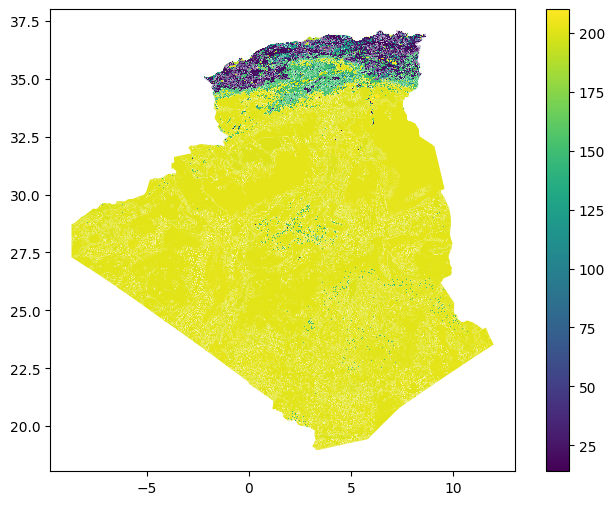

In [4]:

# === 1. Load shapefile ===
landcover_dz = gpd.read_file("../land_dataset/algeria/dza_gc_adg.shp")

# === 2. Basic info ===
print("✅ Landcover Algérie chargé avec succès!")
print("\n📂 Nombre de lignes :", len(landcover_dz))
print("📋 Colonnes :", list(landcover_dz.columns))
print("\n🗺️ Type de géométrie :", landcover_dz.geom_type.unique())
print("🌍 Système de coordonnées :", landcover_dz.crs)

# === 3. Aperçu des données ===
print("\n🔹 Aperçu des 5 premières lignes :")
display(landcover_dz.head())



# === 5. Vérifier les valeurs uniques d’une colonne importante (ex: 'GRIDCODE') ===
if "GRIDCODE" in landcover_dz.columns:
    print("\n🌿 Valeurs uniques de GRIDCODE :")
    print(landcover_dz["GRIDCODE"].unique())

# === 6. Visualiser rapidement ===
landcover_dz.plot(column="GRIDCODE" if "GRIDCODE" in landcover_dz.columns else None,
                  legend=True,
                  figsize=(8, 6))


## Fire Dataset

### Algeria

✅ Fire data loaded: 87446 rows


,latitude,longitude,bright_ti4,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_ti5,frp,daynight,type
0,27.72818,9.87200,295.51,0.76,0.77,2024-01-01,3,N20,VIIRS,n,2,277.66,1.24,N,2
1,28.63288,9.77909,301.80,0.79,0.78,2024-01-01,3,N20,VIIRS,n,2,277.05,1.57,N,2
2,28.64012,9.77953,298.65,0.79,0.78,2024-01-01,3,N20,VIIRS,n,2,277.04,1.34,N,2
3,36.74886,6.25409,338.04,0.46,0.39,2024-01-01,141,N20,VIIRS,n,2,257.28,5.21,N,2
4,35.87978,4.44782,309.49,0.41,0.37,2024-01-01,141,N20,VIIRS,n,2,272.08,1.58,N,2


d:\usthb\M2\DataMining\projet\DataMining--Project\DMenv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


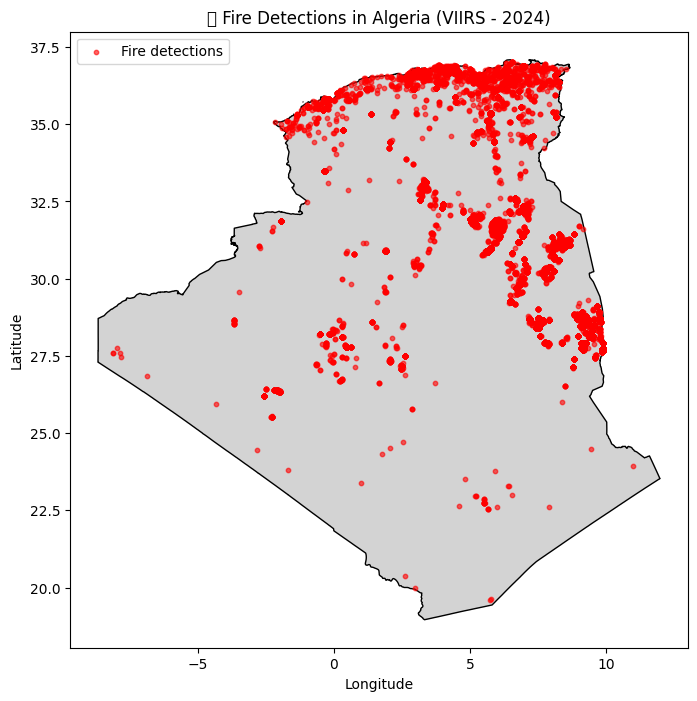

In [5]:

# === 1. Load fire dataset ===
fire_dz = pd.read_csv("../fire_dataset/viirs-jpss1_2024_Algeria.csv")
print("✅ Fire data loaded:", len(fire_dz), "rows")
display(fire_dz.head())

# === 2. Convert to GeoDataFrame ===
geometry = [Point(xy) for xy in zip(fire_dz["longitude"], fire_dz["latitude"])]
fire_gdf = gpd.GeoDataFrame(fire_dz, geometry=geometry, crs="EPSG:4326")  # WGS84

# === 3. Load Algeria shapefile for context ===
algeria = gpd.read_file("../shapefiles/algeria/gadm41_DZA_0.shp")

# === 4. Plot fire points over Algeria ===
fig, ax = plt.subplots(figsize=(8, 8))
algeria.plot(ax=ax, color="lightgrey", edgecolor="black")
fire_gdf.plot(
    ax=ax,
    markersize=10,
    c="red",
    alpha=0.6,
    label="Fire detections"
)
plt.title("🔥 Fire Detections in Algeria (VIIRS - 2024)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()

### Tunisia

✅ Fire data loaded: 2804 rows


,latitude,longitude,bright_ti4,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_ti5,frp,daynight,type
0,31.64847,9.16945,315.79,0.53,0.50,2024-01-01,142,N20,VIIRS,n,2,279.09,2.20,N,2
1,31.49290,9.48947,302.32,0.56,0.51,2024-01-01,142,N20,VIIRS,n,2,276.10,1.23,N,0
2,31.49524,9.49053,301.88,0.56,0.51,2024-01-01,142,N20,VIIRS,n,2,276.12,0.77,N,0
3,33.36728,8.54768,302.58,0.45,0.47,2024-01-01,142,N20,VIIRS,n,2,277.15,0.80,N,2
4,31.64812,9.17107,320.80,0.46,0.39,2024-01-02,124,N20,VIIRS,n,2,278.37,2.44,N,2


d:\usthb\M2\DataMining\projet\DataMining--Project\DMenv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


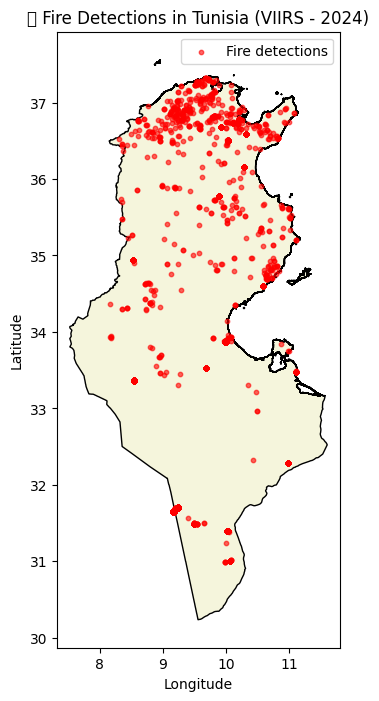

In [6]:


# === 1. Load fire dataset ===
fire_tn = pd.read_csv("../fire_dataset/viirs-jpss1_2024_Tunisia.csv")
print("✅ Fire data loaded:", len(fire_tn), "rows")
display(fire_tn.head())

# === 2. Convert to GeoDataFrame ===
geometry = [Point(xy) for xy in zip(fire_tn["longitude"], fire_tn["latitude"])]
fire_tn_gdf = gpd.GeoDataFrame(fire_tn, geometry=geometry, crs="EPSG:4326")  # WGS84

# === 3. Load Tunisia shapefile ===
tunisia = gpd.read_file("../shapefiles/tunisia/gadm41_TUN_0.shp")

# === 4. Plot fire points over Tunisia ===
fig, ax = plt.subplots(figsize=(8, 8))
tunisia.plot(ax=ax, color="beige", edgecolor="black")
fire_tn_gdf.plot(
    ax=ax,
    markersize=10,
    c="red",
    alpha=0.6,
    label="Fire detections"
)
plt.title("🔥 Fire Detections in Tunisia (VIIRS - 2024)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()


# Soil Dataset

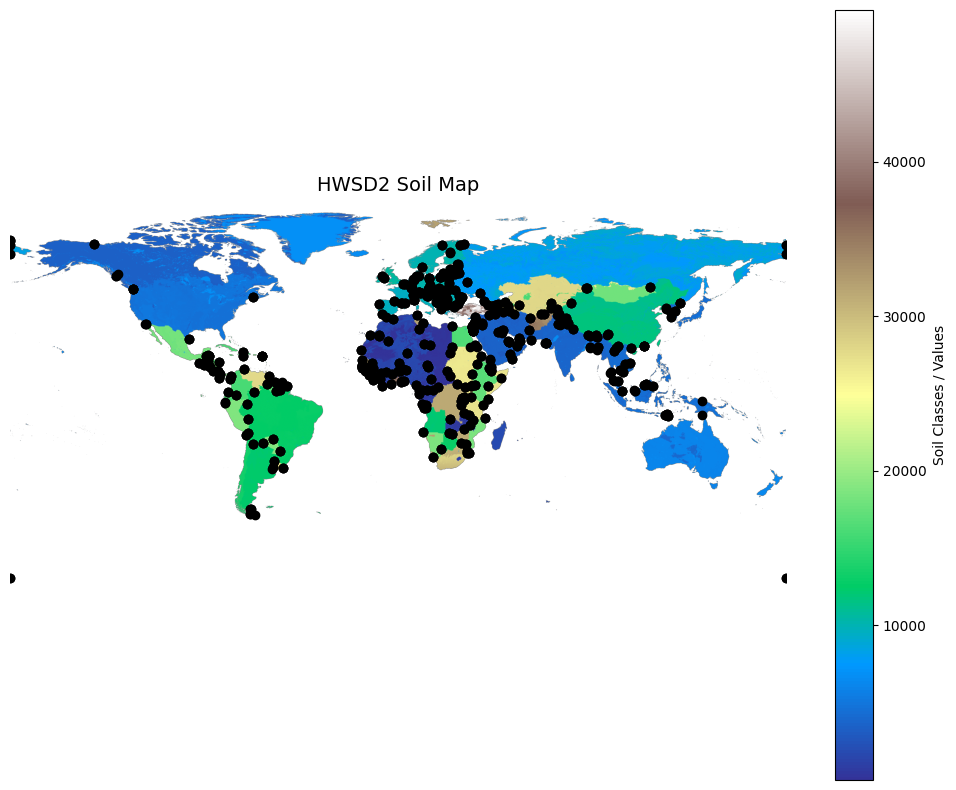

In [18]:

# === Paths ===
base_dir = r"../soil_dataset"
raster_path = os.path.join(base_dir, "HWSD2_RASTER", "HWSD2.bil")
shapefile_path = os.path.join(base_dir, "country.shp")

# === Load shapefile ===
country = gpd.read_file(shapefile_path)

# === Open raster and read data (downsampled to save memory) ===
with rasterio.open(raster_path) as src:
    soil_data = src.read(1, out_shape=(
        int(src.height // 10),
        int(src.width // 10)
    ))
    transform = src.transform * src.transform.scale(
        (src.width / soil_data.shape[-1]),
        (src.height / soil_data.shape[-2])
    )
    nodata_value = src.nodata

# === Mask NoData values ===
if nodata_value is None:
    nodata_value = 0
soil_data = np.where(soil_data == nodata_value, np.nan, soil_data)

# === Plot map ===
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(
    soil_data,
    extent=[
        transform.c,
        transform.c + transform.a * soil_data.shape[1],
        transform.f + transform.e * soil_data.shape[0],
        transform.f
    ],cmap='terrain'
)
country.boundary.plot(ax=ax, color='black', linewidth=1)
plt.colorbar(ax.images[0], ax=ax, label='Soil Classes / Values')
plt.title("HWSD2 Soil Map", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

## ShapeFiles

### Algeria

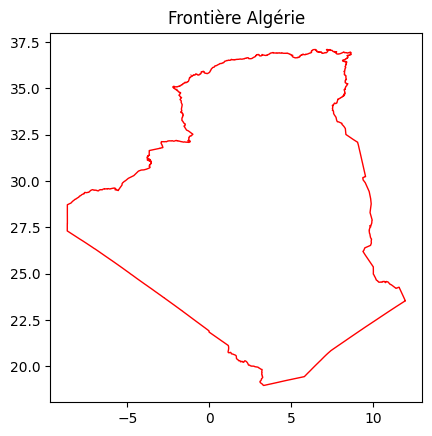

In [8]:
algeria_poly = gpd.read_file("../shapefiles/algeria/gadm41_DZA_0.shp")
algeria_poly.plot(edgecolor='red', facecolor='none')
plt.title("Frontière Algérie")
plt.show()


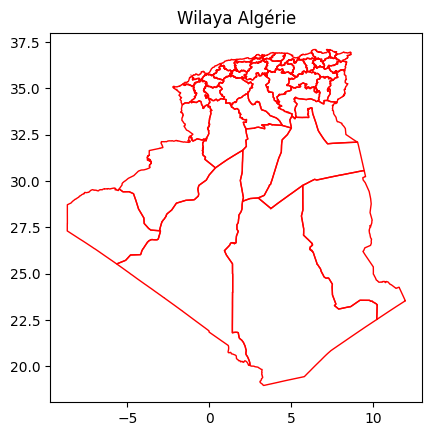

In [9]:
algeria_poly = gpd.read_file("../shapefiles/algeria/gadm41_DZA_1.shp")
algeria_poly.plot(edgecolor='red', facecolor='none')
plt.title("Wilaya Algérie")
plt.show()

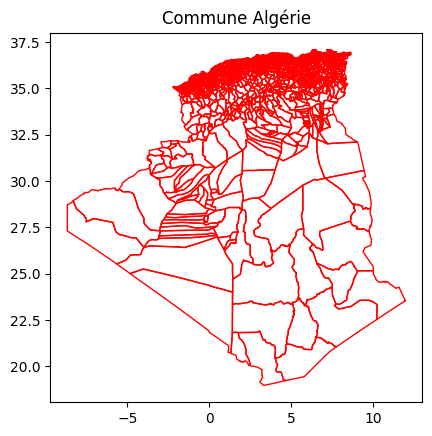

In [10]:
algeria_poly = gpd.read_file("../shapefiles/algeria/gadm41_DZA_2.shp")
algeria_poly.plot(edgecolor='red', facecolor='none')
plt.title("Commune Algérie")
plt.show()

### Tunisia

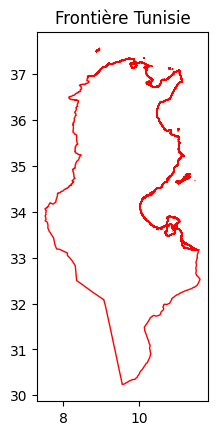

In [11]:
algeria_poly = gpd.read_file("../shapefiles/tunisia/gadm41_TUN_0.shp")
algeria_poly.plot(edgecolor='red', facecolor='none')
plt.title("Frontière Tunisie")
plt.show()


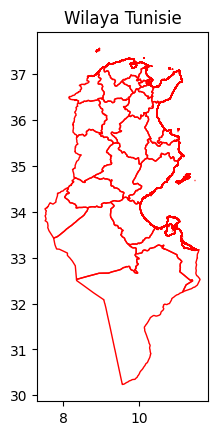

In [12]:
algeria_poly = gpd.read_file("../shapefiles/tunisia/gadm41_TUN_1.shp")
algeria_poly.plot(edgecolor='red', facecolor='none')
plt.title("Wilaya Tunisie")
plt.show()

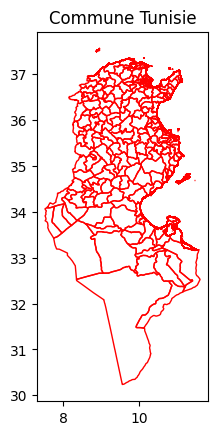

In [13]:
algeria_poly = gpd.read_file("../shapefiles/tunisia/gadm41_TUN_2.shp")
algeria_poly.plot(edgecolor='red', facecolor='none')
plt.title("Commune Tunisie")
plt.show()

## Worldwide Clip 

In [ ]:


def clip_raster_to_shape(raster_path, shape_path):
    # Read geometry
    with fiona.open(shape_path) as shape:
        geoms = [feature["geometry"] for feature in shape]

    # Open and clip
    with rasterio.open(raster_path) as src:
        out_image, out_transform = mask(src, geoms, crop=True)
        out_image = out_image[0].astype(float)

        # Handle NoData values
        nodata = src.nodata
        if nodata is not None:
            out_image[out_image == nodata] = np.nan

    # Display with a clear colormap
    plt.imshow(out_image, cmap='terrain')
    plt.title("Clipped Raster")
    plt.axis("off")
    plt.colorbar(label="Elevation (m)")
    plt.show()





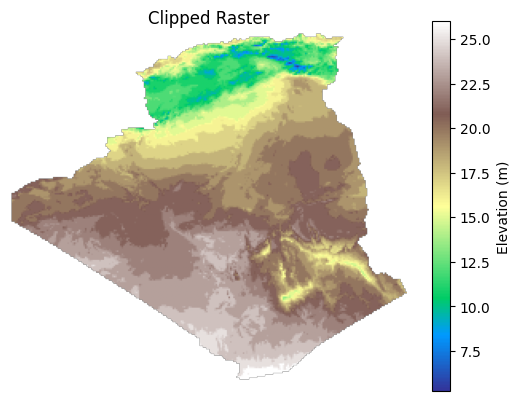

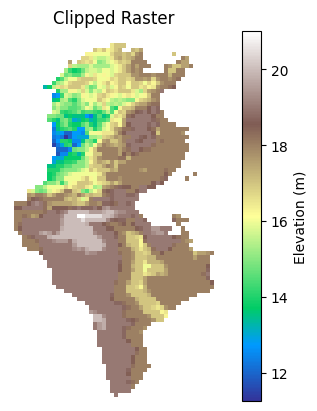

In [15]:
# Algérie
clip_raster_to_shape("../climate_dataset/5min/max/wc2.1_cruts4.09_5m_tmax_2020-01.tif",
                     "../shapefiles/algeria/gadm41_DZA_0.shp")

# Tunisie
clip_raster_to_shape("../climate_dataset/5min/max/wc2.1_cruts4.09_5m_tmax_2020-01.tif",
                     "../shapefiles/tunisia/gadm41_TUN_0.shp")


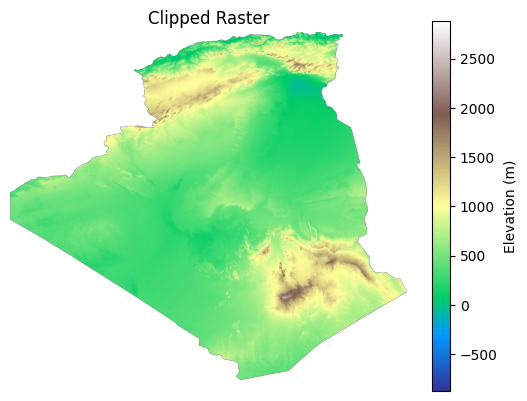

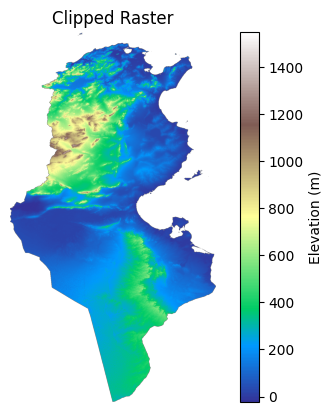

In [16]:
# Algérie
clip_raster_to_shape("../elevation_dataset/be15_grd/w001001.adf",
                     "../shapefiles/algeria/gadm41_DZA_0.shp")

# Tunisie
clip_raster_to_shape("../elevation_dataset/be15_grd/w001001.adf",
                     "../shapefiles/tunisia/gadm41_TUN_0.shp")



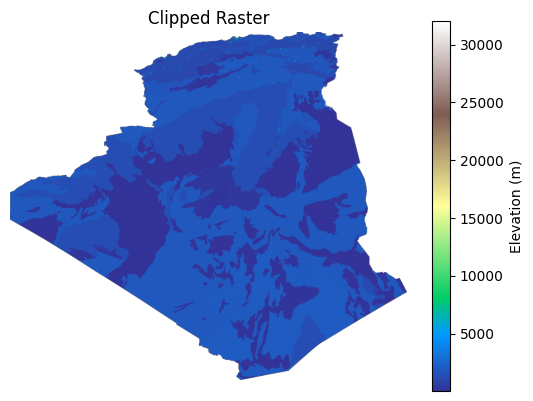

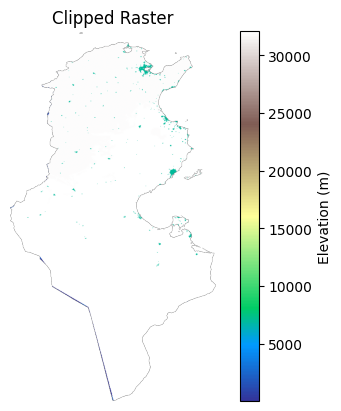

In [17]:
# Algérie
clip_raster_to_shape("../soil_dataset/HWSD2_RASTER/HWSD2.bil",
                     "../shapefiles/algeria/gadm41_DZA_0.shp")

# Tunisie
clip_raster_to_shape("../soil_dataset/HWSD2_RASTER/HWSD2.bil",
                     "../shapefiles/tunisia/gadm41_TUN_0.shp")
